In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image 
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
# Load the CSV file containing image filenames and one-hot encoded labels
labels_df = pd.read_csv('/kaggle/input/celeba-dataset/list_attr_celeba.csv')

labels_df.set_index("image_id", inplace=True)
labels_df.replace(-1,0, inplace=True)
labels_df

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [21]:
labels_df.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [4]:
# choose the following features
selected_columns = ["Bald", "Black_Hair", "Blond_Hair", "Eyeglasses", "Goatee", "Male", "Mustache", "Smiling"]
missing_columns = [col for col in selected_columns if col not in labels_df.columns]
if not missing_columns:
    labels_df = labels_df[selected_columns]
else:
    print("The following columns are missing:", missing_columns)

In [23]:
labels_df

,Bald,Black_Hair,Blond_Hair,Eyeglasses,Goatee,Male,Mustache,Smiling
image_id,,,,,,,,
000001.jpg,0,0,0,0,0,0,0,1
000002.jpg,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,1,0,0
000004.jpg,0,0,0,0,0,0,0,0
000005.jpg,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,0,0
202596.jpg,0,0,1,0,0,1,0,1
202597.jpg,0,1,0,1,0,1,0,1


In [5]:
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=10)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=10)

In [6]:
class CelebADataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.index[idx])
        image = Image.open(img_name)
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        labels = self.df.iloc[idx].values.astype("float32")

        return image, labels

# Initialize datasets
train_dataset = CelebADataset(train_df, "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba")
val_dataset = CelebADataset(val_df, "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba" )
test_dataset = CelebADataset(test_df, "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba")

In [7]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [8]:
# actually it has 10 childs, so by mistake I make it this to learn only the fc layer but results seems enough
model = models.resnext50_32x4d(pretrained=True)
for i, (name, children) in enumerate(model.named_children()):
    if(i <= 10):
        print(f"param:{name}, i:{i} freezed")
        children.requires_grad = False
    
    
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, len(train_df.columns))
criterion = nn.BCEWithLogitsLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 87.8MB/s]


param:conv1, i:0 freezed
param:bn1, i:1 freezed
param:relu, i:2 freezed
param:maxpool, i:3 freezed
param:layer1, i:4 freezed
param:layer2, i:5 freezed
param:layer3, i:6 freezed
param:layer4, i:7 freezed
param:avgpool, i:8 freezed
param:fc, i:9 freezed


In [9]:
weight_path = "/kaggle/input/celeba_selected/pytorch/last/1/resnet50_celeba_weights.pth"

In [10]:
import copy

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = criterion.to(device)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = 0
    early_stopping_patience = 5
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)')

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_pbar.set_postfix(loss=loss.item())

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0
        val_acc = 0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)')

        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                loss = criterion(output, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = (output > 0).float()
                val_acc += (preds == labels).float().mean()
                val_pbar.set_postfix(loss=loss.item(), acc=val_acc/(val_pbar.n+1))

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_acc / len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    print(f'Best Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch}')
    model.load_state_dict(best_model_wts)
    return model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
if(not os.path.exists(weight_path)):
    model = train(model, train_loader, val_loader, criterion, optimizer, 10)
else:
    model.load_state_dict(torch.load(weight_path))

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

def test(model, test_loader, criterion, device, class_names = test_df.columns.tolist()):
    model.to(test_device)
    model.eval()
    test_loss = 0
    test_acc = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing')
        for inputs, labels in test_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item() * inputs.size(0)
            
            # For multi-label classification, apply a sigmoid and then convert to binary outputs
            preds = torch.sigmoid(output).data > 0.5
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

            # Calculating the batch accuracy
            batch_correct = preds.eq(labels.data).float()
            batch_acc = batch_correct.mean()  # Mean accuracy of the batch
            test_acc += batch_acc.item()
            test_pbar.set_postfix(loss=loss.item(), acc=batch_acc.item())

    # Concatenating all predictions and labels across all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute the confusion matrix
    confusion_matrix = multilabel_confusion_matrix(all_labels.numpy(), all_preds.numpy(), labels=np.arange(len(class_names)))

    # Final test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    print('Confusion Matrix for each label:')
    
    # Visualization of the confusion matrices
    for i, matrix in enumerate(confusion_matrix):
        print(f"Label: {class_names[i]}")
        print(matrix)
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {class_names[i]}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

In [ ]:
torch.save(model.state_dict(), 'resnet50_celeba_weights.pth')

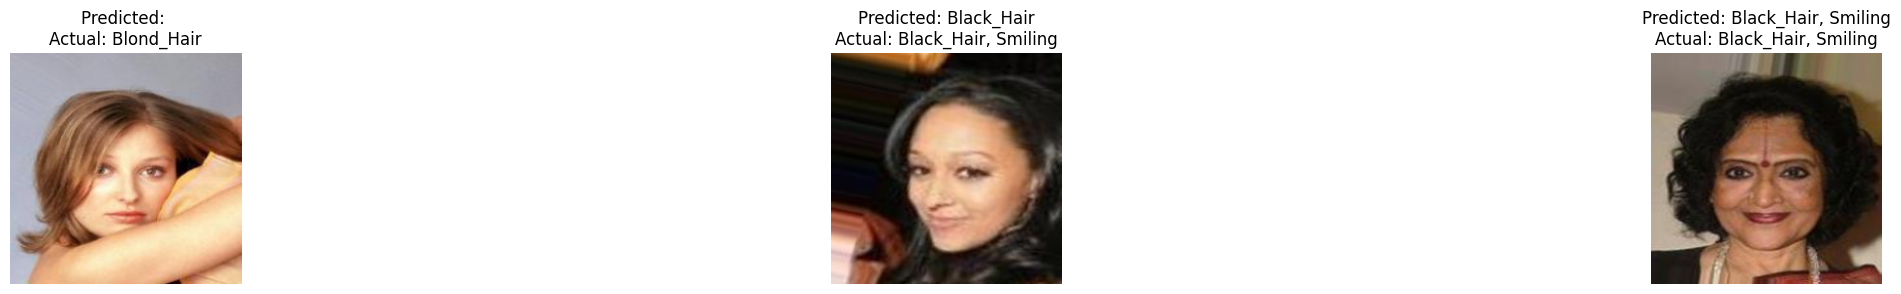

Testing: 100%|██████████| 317/317 [07:04<00:00,  1.34s/it, acc=0.964, loss=0.0762]


Test Loss: 0.0925, Test Accuracy: 0.9611
Confusion Matrix for each label:
Label: Bald
[[39264   346]
 [  142   768]]


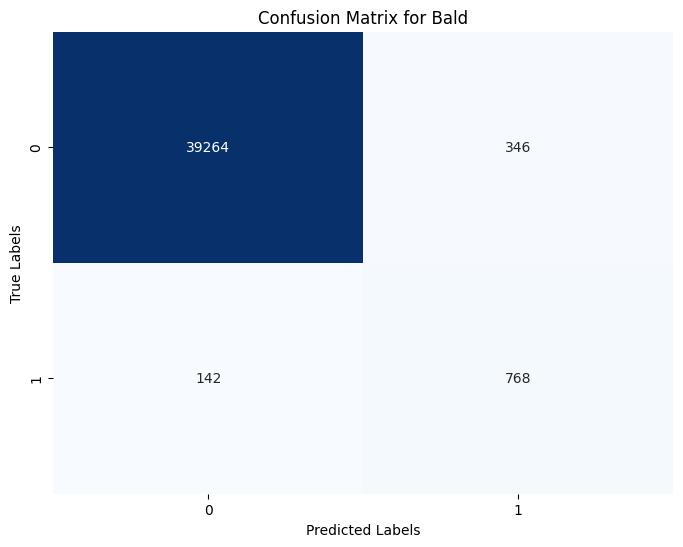

Label: Black_Hair
[[28961  1873]
 [ 1860  7826]]


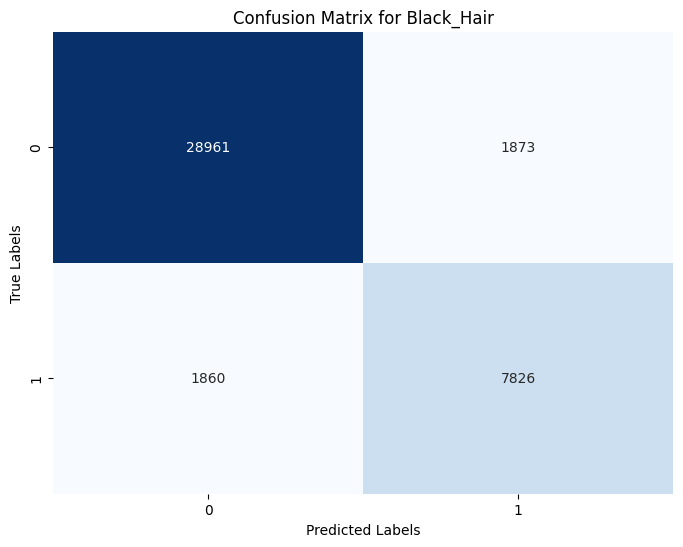

Label: Blond_Hair
[[33813   747]
 [  999  4961]]


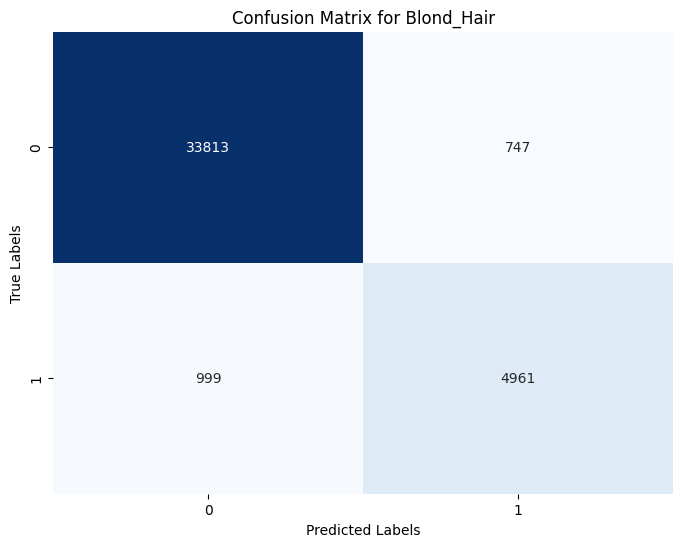

Label: Eyeglasses
[[37746   103]
 [   87  2584]]


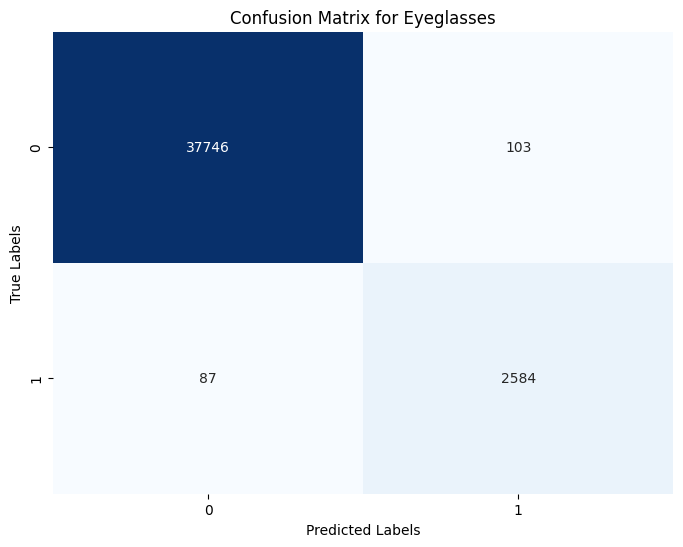

Label: Goatee
[[37095   831]
 [  457  2137]]


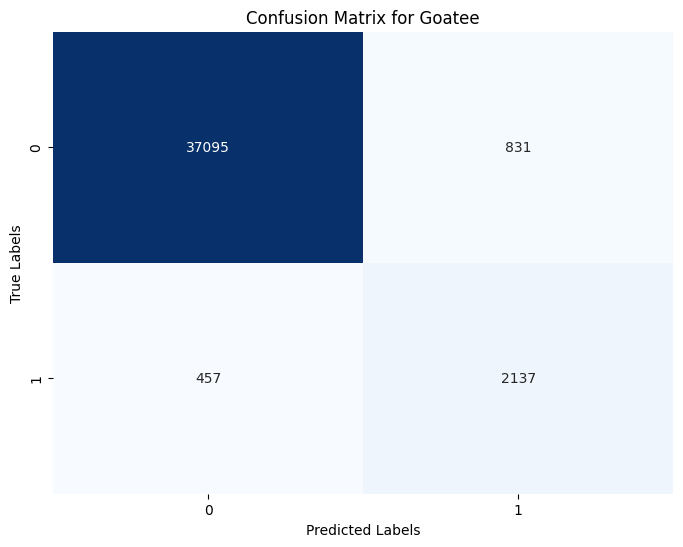

Label: Male
[[23130   541]
 [  246 16603]]


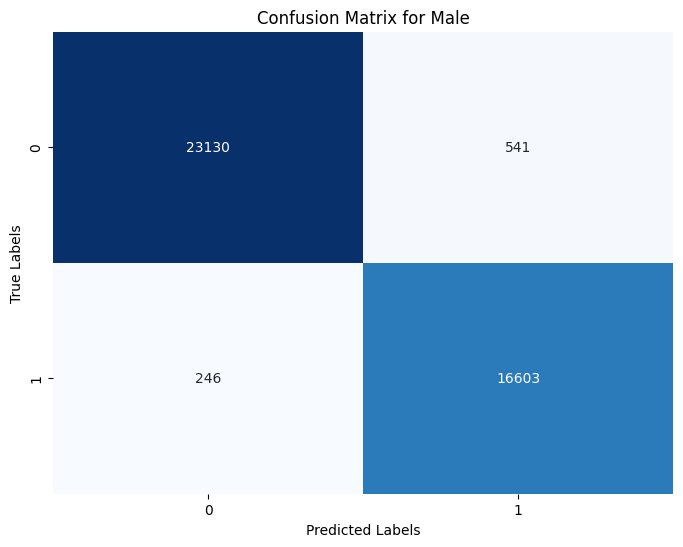

Label: Mustache
[[38735   131]
 [ 1275   379]]


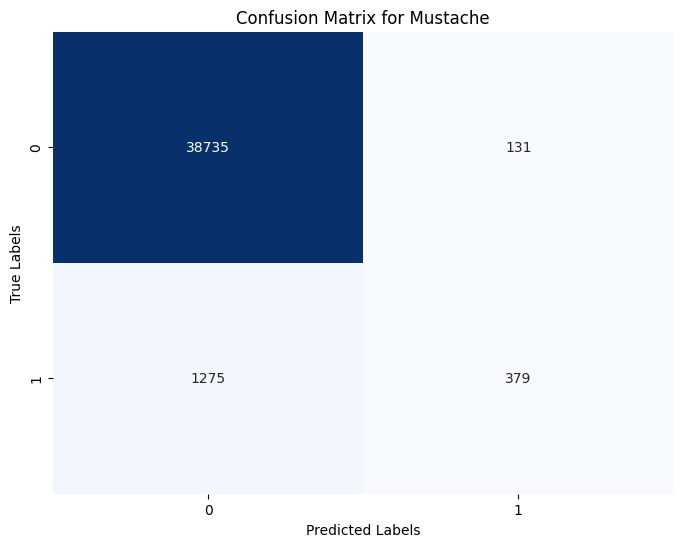

Label: Smiling
[[20154   900]
 [ 2068 17398]]


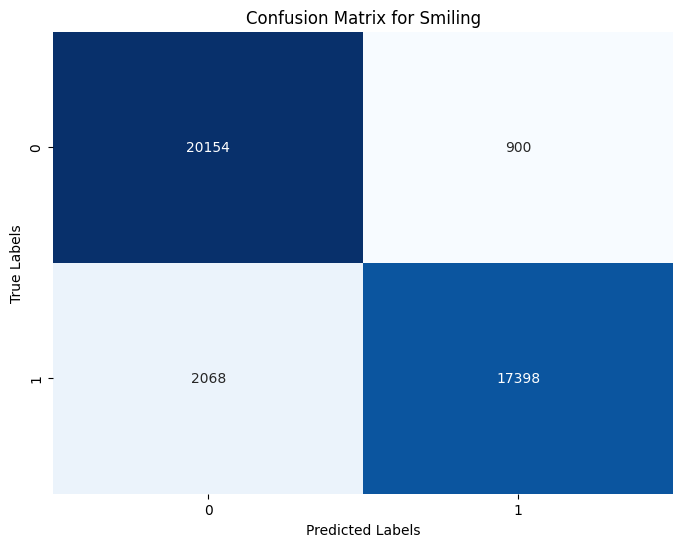

In [15]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import torchvision.transforms as transforms

def visualize_random_predictions(model, df, root_dir, device, num_samples=3):
    model.to(device)
    model.eval()
    samples = df.sample(n=num_samples)  # Randomly sample the dataframe
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    fig, axes = plt.subplots(1, num_samples, figsize=(10*num_samples, 3))
    
    with torch.no_grad():
        for i, (_, row) in enumerate(samples.iterrows()):
            img_path = os.path.join(root_dir, row.name)
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform(image).unsqueeze(0).to(device)
            outputs = model(image_tensor)
            preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold
            
            predicted_labels = [df.columns[j] for j, pred in enumerate(preds.cpu().numpy().flatten()) if pred]  # +1 to adjust index for image_id column
            actual_labels = [df.columns[j] for j, act in enumerate(row) if act == 1]
            
            
            mean=torch.tensor([0.485, 0.456, 0.406])
            std=torch.tensor([0.229, 0.224, 0.225])

            inverse_norm = transforms.Normalize(mean = -mean/std, std = 1/std)
            ax = axes[i]
            ax.imshow(inverse_norm(image_tensor.cpu().squeeze()).numpy().transpose(1, 2, 0))
            ax.axis('off')
            ax.set_title(f'Predicted: {", ".join(predicted_labels)}\nActual: {", ".join(actual_labels)}')

    plt.show()
test_root_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
test_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualize predictions on random test samples
visualize_random_predictions(model, test_df, test_root_dir, test_device)
    
criterion = criterion.to(test_device)
test(model, test_loader, criterion, test_device)

In [18]:
"""
# Convert the list of lists to numpy array
labels = np.array(labels)

labels[labels == -1] = 0  # Replace -1 with 0 for negative classes

# Create a list of image filenames
image_filenames = labels_df['image_id'].tolist()

# Split dataset into train and validation sets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(image_filenames, labels, test_size=0.2, random_state=42)

# Use MultiLabelBinarizer to convert the one-hot encoded labels to a numpy array
# labels_df = pd.read_csv('labels.csv')
# mlb = MultiLabelBinarizer()
# labels = mlb.fit_transform(labels_df.iloc[:, 1:].values)

# Define a custom dataset class to load images and labels
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, filenames, labels):
        self.image_folder = image_folder
        self.filenames = filenames
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.filenames[idx])
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        label = torch.FloatTensor(self.labels[idx])
        return image, label

# Create custom datasets for train and validation
train_dataset = CustomDataset('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba', train_filenames, train_labels)
val_dataset = CustomDataset('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba', val_filenames, val_labels)

# Create DataLoader for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
"""

"\n# Convert the list of lists to numpy array\nlabels = np.array(labels)\n\nlabels[labels == -1] = 0  # Replace -1 with 0 for negative classes\n\n# Create a list of image filenames\nimage_filenames = labels_df['image_id'].tolist()\n\n# Split dataset into train and validation sets\ntrain_filenames, val_filenames, train_labels, val_labels = train_test_split(image_filenames, labels, test_size=0.2, random_state=42)\n\n# Use MultiLabelBinarizer to convert the one-hot encoded labels to a numpy array\n# labels_df = pd.read_csv('labels.csv')\n# mlb = MultiLabelBinarizer()\n# labels = mlb.fit_transform(labels_df.iloc[:, 1:].values)\n\n# Define a custom dataset class to load images and labels\nclass CustomDataset(torch.utils.data.Dataset):\n    def __init__(self, image_folder, filenames, labels):\n        self.image_folder = image_folder\n        self.filenames = filenames\n        self.labels = labels\n        self.transform = transforms.Compose([\n            transforms.Resize((224, 224)),\n  

In [ ]:
"""
import matplotlib.pyplot as plt

idx = 2
image, labels = val_dataset[idx]
# Convert one-hot encoded labels to attribute names
attribute_names = [labels_df.columns[i] for i in range(1, 41)]  # Replace with your attribute names
selected_attributes = [attribute_names[i] for i in range(len(labels)) if labels[i] == 1]

# Convert image tensor to numpy array
image = image.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image)
plt.axis('off')

# Display the labels
plt.title(', '.join(selected_attributes))
plt.show()
"""

In [ ]:
"""
from tqdm import tqdm

# Define a function for validation
def validate(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during validation
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            predicted = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total
    return val_loss, val_accuracy

# Use the model and DataLoader defined earlier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with a new one suitable for 40 attributes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 40)  # Output size is 40 for 40 attributes

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
# Save the fine-tuned model
torch.save(model.state_dict(), 'celeba_resnet50_finetuned.pth')
"""

In [ ]:
"""
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import pandas as pd

labels_df = pd.read_csv('/kaggle/input/celeba-dataset/list_attr_celeba.csv')
attributes = labels_df.columns
print(attributes)
# Load the trained model
model = models.resnet50(pretrained=False)  # Load pretrained ResNet50 model
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 40)

model.load_state_dict(torch.load('/kaggle/input/classifier_v1/pytorch/v1/1/celeba_resnet50_finetuned.pth'))
model.eval()  # Set the model to evaluation mode

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(image)

# Convert output to probabilities and extract predicted labels
probabilities = torch.sigmoid(output)
print(probabilities)
predicted_labels = (probabilities > 0.5).squeeze().numpy()  # Assuming threshold of 0.5 for binary classification

# Display predicted labels
print("Predicted Labels:")
for i, label in enumerate(predicted_labels):
    if label == 1:
        print(f"Attribute {i+1}: Present")
    else:
        print(f"Attribute {i+1}: Absent")
"""